In [1]:
import numpy as np
import googlemaps
import CycleGan
import glob
import imageio
import scipy
import matplotlib.pyplot as plt
import bisect

Using TensorFlow backend.


## Pre Processing

In [3]:
path=".\\data\\Japanese\\"

trainA=glob.glob(path+"trainA\\*.jpg")
trainB=glob.glob(path+"trainB\\*.jpg")

In [4]:
trainA_dim=[]
for i in trainA:
    img=imageio.imread(i)
    trainA_dim.append(img.shape)

Text(0.5, 1.0, 'image dimensions')

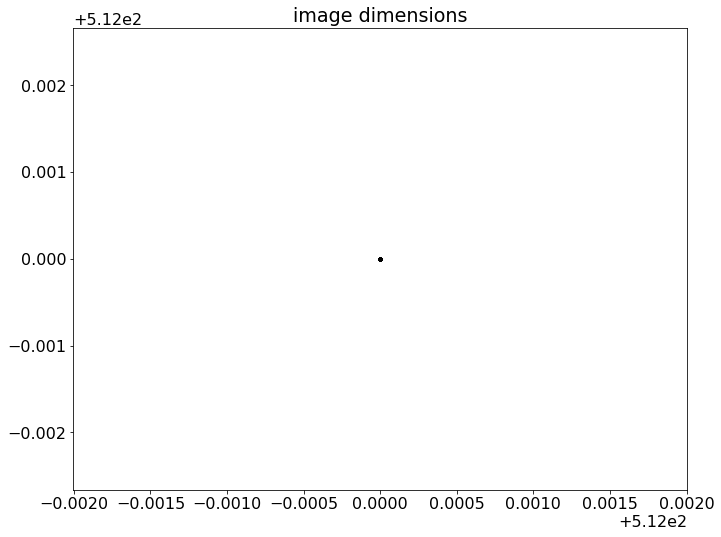

In [5]:
y,x=np.array(trainA_dim)[:,0], np.array(trainA_dim)[:,1]

plt.rcParams.update({'font.size':16})
fig,ax=plt.subplots(1, figsize=[11,8.5])
ax.scatter(x,y, s=5, color='black')
ax.set_title("image dimensions")

In [6]:
trainB_dim=[]
for i in trainB:
    img=imageio.imread(i)
    trainB_dim.append(img.shape)

Text(0.5, 1.0, 'image dimensions')

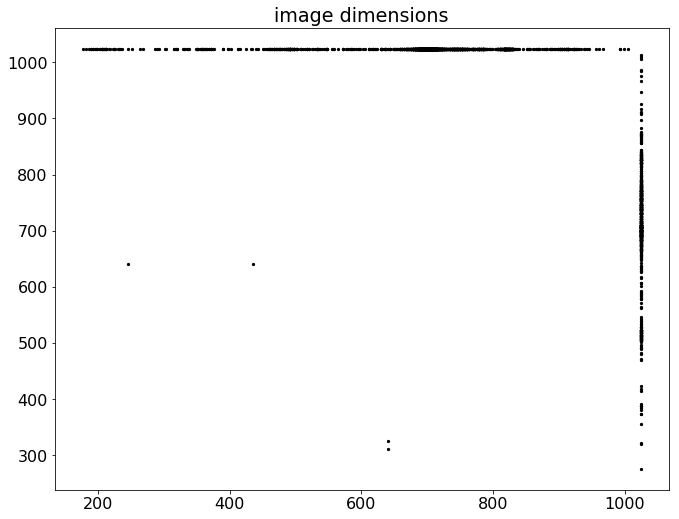

In [7]:
y,x=np.array(trainB_dim)[:,0], np.array(trainB_dim)[:,1]

plt.rcParams.update({'font.size':16})
fig,ax=plt.subplots(1, figsize=[11,8.5])
ax.scatter(x,y, s=5, color='black')
ax.set_title("image dimensions")

In [8]:
from PIL import Image

def preproc_gray(img_path, output_dir,resize=(512,512)):
    img = Image.open(img_path)
    img = np.array(img)
    
    assert len(img.shape)==2
    v,h = img.shape
    
    if (v>resize[0])*(h>resize[1]):
        
        print(img.shape)
        plt.imshow(img)
        plt.show()

        smallest=min(v, h)
        aspect_ratio=v/h
        adjust_ratio=resize[0]/smallest
        new_h=round(adjust_ratio*h)
        new_v=round(adjust_ratio*v)
        #print("new_ind2",new_ind2)
        #print("new ind1",new_ind1)
        
        print(type(img))
        img=Image.fromarray(img)
        img=img.resize((new_h,new_v))
        img=np.array(img)
        print('after image resize: ', img.shape)
        plt.imshow(img)
        plt.show()

        #find which is 512
        if new_v==512: # if v is 512
            diff=new_h-512
            img=img[ : , int(0+diff/2) : int(new_h-diff/2) ]
            plt.imshow(img)
            plt.show()

        elif new_h==512: # if ind2 is 512
            diff=new_v-512
            img=np.array(img)[ int(0+diff/2) : int(new_v-diff/2) , : ]
            plt.imshow(img)
            plt.show()
        
        #print(np.array(img).shape)
        
        savename=img_path.split("\\")[-1].split(".")[0]
        #print(savename)
        img=Image.fromarray(img)
        img.save(output_dir + savename  +  ".jpg")

        
        
        
def preproc_RGB(img_path, output_dir,resize=(512,512)):
    img = Image.open(img_path)
    img = np.array(img)
    
    assert len(img.shape)==3
    v,h = img.shape[:2]
    
    if (v>resize[0])*(h>resize[1]):
        

        smallest=min(v, h)
        aspect_ratio=v/h
        adjust_ratio=resize[0]/smallest
        new_h=round(adjust_ratio*h)
        new_v=round(adjust_ratio*v)
        
        img=Image.fromarray(img)
        img=img.resize((new_h,new_v))
        img=np.array(img)

        #find which is 512
        if new_v==512: # if v is 512
            diff=new_h-512
            img=img[ : , int(0+diff/2) : int(new_h-diff/2) ,:]

        elif new_h==512: # if ind2 is 512
            diff=new_v-512
            img=np.array(img)[ int(0+diff/2) : int(new_v-diff/2) , : ,:]
        
        
        savename=img_path.split("\\")[-1].split(".")[0]
        img=Image.fromarray(img)
        img.save(output_dir + savename  +  ".jpg")


In [9]:
assert False:
for i in trainA:
    preproc_gray(i,".\\data\\Japanese\\trainA_preproc\\")

SyntaxError: invalid syntax (<ipython-input-9-75289a6e9d94>, line 1)

In [10]:
assert False
for i in trainB:
    preproc_RGB(i,".\\data\\Japanese\\trainB_preproc\\")

AssertionError: 

## cyclegan

In [106]:
cyclegan=CycleGan.CycleGan('.\\data\\Japanese\\', 512,512, 3, 15)

In [107]:
assert False # prevent run
p=cyclegan.train(epochs=45,batch_size=1, sample_interval=5, show_img=False)

AssertionError: 

## Output

In [135]:
cyclegan=CycleGan.CycleGan('.\\data\\Japanese\\', 512,512, 3, 15)
genXY=cyclegan.return_genXY()
genYX=cyclegan.return_genYX()

genXY.load_weights(".\\data\\Japanese\\models\\JapanesemodelgenXY_40_1_15")
genYX.load_weights(".\\data\\Japanese\\models\\JapanesemodelgenYX_40_1_15")

In [136]:
import scipy.misc

def img_range(img):
    return ((img+1)*127.5).astype(np.int32)

def ceil(numb):
    return -(-numb//1)

def make_512_512(img, troubleshoot=False):
    v,h = img.shape[:2]
    
    smallest=min(v,h)
    adjust_ratio=512/smallest
    new_v=round(v*adjust_ratio)
    new_h=round(h*adjust_ratio)
    if troubleshoot:
        print("v: ", v)
        print("h: ", h)
        print("adjust ratio: ", adjust_ratio)
        print("new_v: ", new_v)
        print("new_h: ", new_h)
    
    scaled_down_image=scipy.misc.imresize(img, (new_v, new_h, 3))
    
    # case 1: new_v is 512
    if new_v==512:
        diff=new_h-512
        if troubleshoot:
            print("diff: ",diff)
            print("new_v is 512: ", int(diff/2)," ", new_h - int(ceil(diff/2)))
        new_img=scaled_down_image[:, int(diff/2) : new_h - int(ceil(diff/2)), :]
        return new_img
    
    # case 2: new_h is 512
    elif new_h==512:
        diff=new_v-512
        if troubleshoot:
            print("diff: ", diff)
            print("new_h is 512: ", int(diff/2)," ",  new_v - int(ceil(diff/2)))
        new_img=scaled_down_image[ int(diff/2) :  new_v - int(ceil(diff/2)) , : , :]
        return new_img
    
    elif (new_h==512)*(new_v==512):
        return scaled_down_image
    
    else:
        raise ValueError("This should not happen")

## Before color adjustment

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


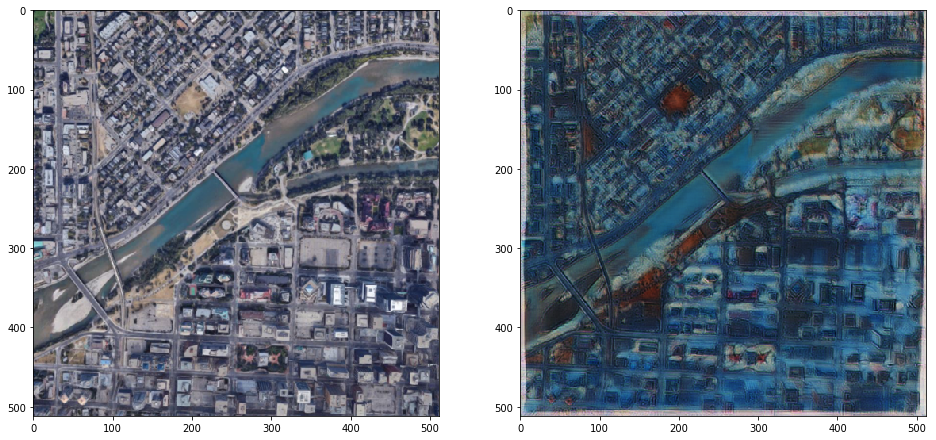

In [137]:
fig,ax=plt.subplots(1,2, figsize=[16,8.5])

path="C:\\Users\\David\\Desktop\\CycleGan\\data\\Japanese\\Prince's island.jpg"
img=imageio.imread(path)
img=make_512_512(img, troubleshoot=False)
ax[0].imshow(img)

transform_img=genXY.predict(img.reshape(1,512,512,3)/127.5-1)
ax[1].imshow(img_range(transform_img.reshape(512,512,3)))

plt.show()

## adjust color distribution

In [138]:
import ImageProcessing
IP=ImageProcessing.ImageProcessing()

## Color spectrum visualization

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


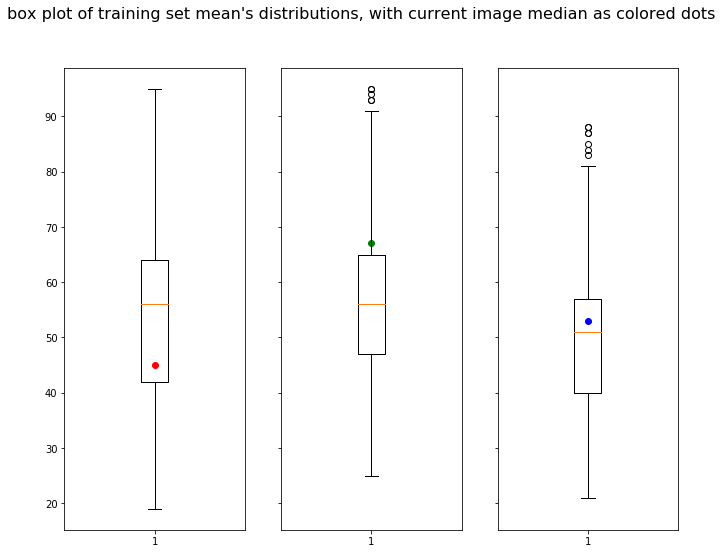

In [139]:
path="C:\\Users\\David\\Desktop\\CycleGan\\data\\Japanese\\trainA\\*.jpg"
trainA=glob.glob(path)
r_med=[]
g_med=[]
b_med=[]
for i in trainA:
    img=imageio.imread(i)
    r_med.append(np.median(img[:,:,0]))
    g_med.append(np.median(img[:,:,1]))
    b_med.append(np.median(img[:,:,2]))
r_med_med =np.median(r_med)
g_med_med =np.median(g_med)
b_med_med =np.median(b_med)


fig,ax=plt.subplots(1,3,figsize=[11,8.5], sharey=True)
ax[0].boxplot(r_med)
ax[1].boxplot(g_med)
ax[2].boxplot(b_med)

path="C:\\Users\\David\\Desktop\\CycleGan\\data\\Japanese\\Calgary.jpg"
img=imageio.imread(path)
img=make_512_512(img)
ax[0].scatter(1,np.median(img[:,:,0]), color='red')
ax[1].scatter(1,np.median(img[:,:,1]), color='green')
ax[2].scatter(1,np.median(img[:,:,2]), color='blue')

fig.suptitle("box plot of training set mean's distributions, with current image median as colored dots", fontsize=16)
plt.show()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


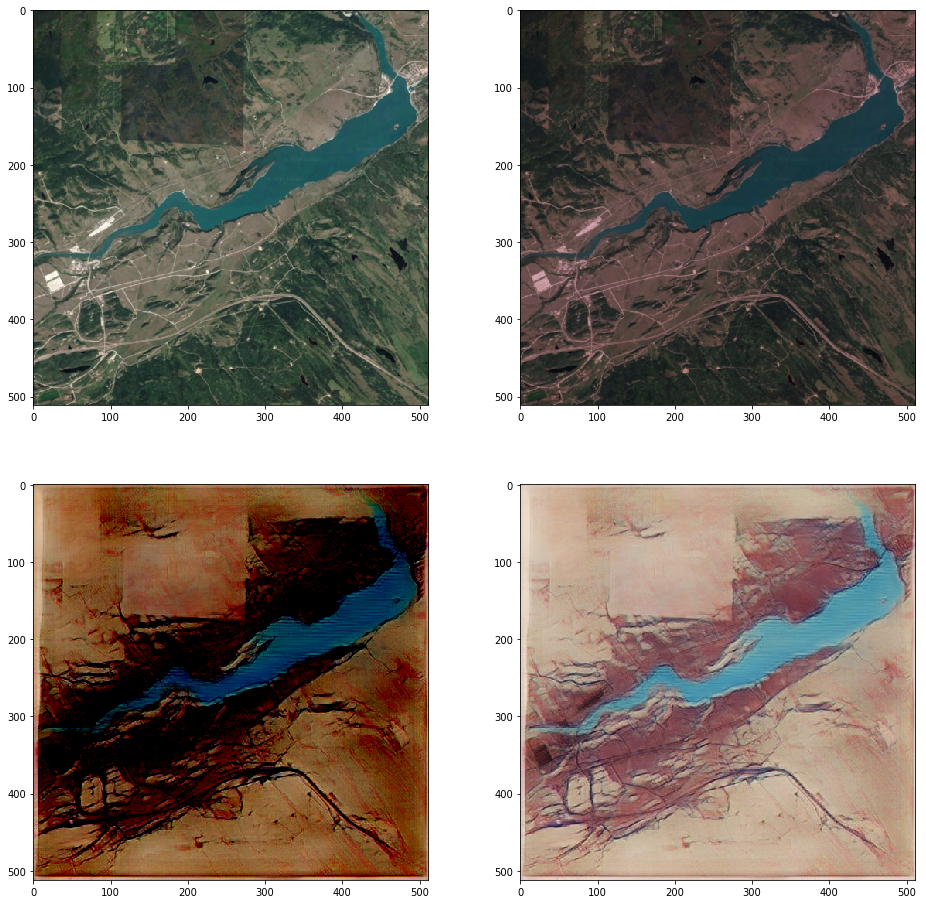

In [210]:
from PIL import Image
fig,ax=plt.subplots(2,2, figsize=[16,16])

name="GhostLake"
path_from="C:\\Users\\David\\Desktop\\CycleGan\\data\\Japanese\\MakeIamges\\Map\\"
path_to="C:\\Users\\David\\Desktop\\CycleGan\\data\\Japanese\\MakeIamges\\Japanese_Style_Map\\"
img=imageio.imread(path_from + name + ".jpg")
img=make_512_512(img, troubleshoot=False)
result = Image.fromarray(img.astype('uint8'))
result.save(path_to+'original_%s.jpg' % name)
ax[0,0].imshow(img)

new_img=IP.adjust_RGB_color_distribution(img, (r_med_med, g_med_med, b_med_med), mode='median')
ax[0,1].imshow(new_img)
#print(new_img.shape)
#print(new_img.reshape(1,512,512,3)/127.5-1)

transform_img=genXY.predict(new_img.reshape(1,512,512,3)/127.5-1)
ax[1,0].imshow(transform_img.reshape(512,512,3))
ax[1,1].imshow(img_range(transform_img.reshape(512,512,3)))
#print(img_range(transform_img.reshape(512,512,3)))

result = Image.fromarray(img_range(transform_img.reshape(512,512,3)).astype('uint8'))
result.save(path_to+'transformed_%s.jpg' % name)